In [2]:
import os
import pickle

import numpy as np
import pandas as pd
import timm
import torch
import torch.nn as nn
from albumentations import CenterCrop, Compose, Normalize
from albumentations.pytorch import ToTensorV2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (average_precision_score, balanced_accuracy_score,
                             matthews_corrcoef, roc_auc_score)
from sklearn.model_selection import GroupKFold
from torch.utils.data import DataLoader
from tqdm import tqdm

from clmodel.dataset import CLModelDataset
from clmodel.data_split import RepeatedStratifiedGroupKFold
from clmodel.model import EffnetB4ModelMO, FrozenEffnetB4ModelMO
from clmodel.utils import fix_seed

In [3]:
import pandas as pd
moa_df = pd.read_csv("../../data/TGGATEs/processed/moa.csv").rename(columns={"Unnamed: 0":"COMPOUND_NAME"})
moa_df

,COMPOUND_NAME,Bacterial 70S ribosome inhibitor,Serotonin 2a (5-HT2a) receptor antagonist,DNA inhibitor,Cyclooxygenase inhibitor,"Sulfonylurea receptor 1, Kir6.2 blocker",Histamine H2 receptor antagonist,Peroxisome proliferator-activated receptor alpha agonist
0,erythromycin ethylsuccinate,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,acetaminophen,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,chlorpromazine,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,ranitidine,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,azathioprine,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,haloperidol,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6,carboplatin,0.0,0.0,1.0,0.0,0.0,0.0,0.0
7,phenylbutazone,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8,cyclophosphamide,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9,naproxen,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [4]:
import numpy as np
info = pd.read_csv("../../data/TGGATEs/processed/info.csv")

moa_df["MoA"] = np.argmax(moa_df[moa_df.columns[1:]].values,axis=1)
moa_info = pd.merge(info, moa_df, on = "COMPOUND_NAME")

moa_info_selected = moa_info[moa_info["SACRI_PERIOD"].isin(["4 day", "8 day", "15 day", "29 day"]) & (moa_info["DOSE"]>0)]
moa_info_selected["EG"] = moa_info_selected["EXP_ID"]*100+moa_info_selected["GROUP_ID"]

moa_info_selected

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,EXP_ID,GROUP_ID,INDIVIDUAL_ID,INDV_ID,COMPOUND_NAME,COMPOUND_ABBR,COMPOUND_NO,SPECIES,TEST_TYPE,SIN_REP_TYPE,...,FILE_LOCATION,Bacterial 70S ribosome inhibitor,Serotonin 2a (5-HT2a) receptor antagonist,DNA inhibitor,Cyclooxygenase inhibitor,"Sulfonylurea receptor 1, Kir6.2 blocker",Histamine H2 receptor antagonist,Peroxisome proliferator-activated receptor alpha agonist,MoA,EG
106,42,9,1,42091,acetaminophen,APAP,1,Rat,in vivo,Repeat,...,ftp://ftp.biosciencedbc.jp/archive/open-tggate...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3,4209
107,42,9,2,42092,acetaminophen,APAP,1,Rat,in vivo,Repeat,...,ftp://ftp.biosciencedbc.jp/archive/open-tggate...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3,4209
108,42,9,3,42093,acetaminophen,APAP,1,Rat,in vivo,Repeat,...,ftp://ftp.biosciencedbc.jp/archive/open-tggate...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3,4209
109,42,9,4,42094,acetaminophen,APAP,1,Rat,in vivo,Repeat,...,ftp://ftp.biosciencedbc.jp/archive/open-tggate...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3,4209
110,42,9,5,42095,acetaminophen,APAP,1,Rat,in vivo,Repeat,...,ftp://ftp.biosciencedbc.jp/archive/open-tggate...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3,4209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5030,577,16,1,577161,carboplatin,CBP,133,Rat,in vivo,Repeat,...,ftp://ftp.biosciencedbc.jp/archive/open-tggate...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2,57716
5031,577,16,2,577162,carboplatin,CBP,133,Rat,in vivo,Repeat,...,ftp://ftp.biosciencedbc.jp/archive/open-tggate...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2,57716
5032,577,16,3,577163,carboplatin,CBP,133,Rat,in vivo,Repeat,...,ftp://ftp.biosciencedbc.jp/archive/open-tggate...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2,57716
5033,577,16,4,577164,carboplatin,CBP,133,Rat,in vivo,Repeat,...,ftp://ftp.biosciencedbc.jp/archive/open-tggate...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2,57716


In [5]:
train = pd.read_csv(f"../../data/TGGATEs/processed/train.csv")
moa_info_test = moa_info_selected[~moa_info_selected["EG"].isin(train["EG"].unique())]
moa_info_test

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,EXP_ID,GROUP_ID,INDIVIDUAL_ID,INDV_ID,COMPOUND_NAME,COMPOUND_ABBR,COMPOUND_NO,SPECIES,TEST_TYPE,SIN_REP_TYPE,...,FILE_LOCATION,Bacterial 70S ribosome inhibitor,Serotonin 2a (5-HT2a) receptor antagonist,DNA inhibitor,Cyclooxygenase inhibitor,"Sulfonylurea receptor 1, Kir6.2 blocker",Histamine H2 receptor antagonist,Peroxisome proliferator-activated receptor alpha agonist,MoA,EG
106,42,9,1,42091,acetaminophen,APAP,1,Rat,in vivo,Repeat,...,ftp://ftp.biosciencedbc.jp/archive/open-tggate...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3,4209
107,42,9,2,42092,acetaminophen,APAP,1,Rat,in vivo,Repeat,...,ftp://ftp.biosciencedbc.jp/archive/open-tggate...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3,4209
108,42,9,3,42093,acetaminophen,APAP,1,Rat,in vivo,Repeat,...,ftp://ftp.biosciencedbc.jp/archive/open-tggate...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3,4209
109,42,9,4,42094,acetaminophen,APAP,1,Rat,in vivo,Repeat,...,ftp://ftp.biosciencedbc.jp/archive/open-tggate...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3,4209
110,42,9,5,42095,acetaminophen,APAP,1,Rat,in vivo,Repeat,...,ftp://ftp.biosciencedbc.jp/archive/open-tggate...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3,4209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5030,577,16,1,577161,carboplatin,CBP,133,Rat,in vivo,Repeat,...,ftp://ftp.biosciencedbc.jp/archive/open-tggate...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2,57716
5031,577,16,2,577162,carboplatin,CBP,133,Rat,in vivo,Repeat,...,ftp://ftp.biosciencedbc.jp/archive/open-tggate...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2,57716
5032,577,16,3,577163,carboplatin,CBP,133,Rat,in vivo,Repeat,...,ftp://ftp.biosciencedbc.jp/archive/open-tggate...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2,57716
5033,577,16,4,577164,carboplatin,CBP,133,Rat,in vivo,Repeat,...,ftp://ftp.biosciencedbc.jp/archive/open-tggate...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2,57716


In [6]:
from glob import glob
moa_tiles = []
for v in moa_info_test["FILE"].to_numpy():
    if type(v) == type(""):
        moa_tiles += glob("/mnt/local/HDD/TGGATE/tiles/"+v+"/*.tiff")


In [7]:
seed = 123
fix_seed(seed)

In [8]:
image_size = 512

vl_transform = Compose([CenterCrop(image_size, image_size), Normalize(), ToTensorV2()])


In [57]:
test_dataset = CLModelDataset(
    moa_tiles, [0]*len(moa_tiles), transform=vl_transform
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    drop_last=False,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
)

model_control = timm.create_model("tf_efficientnet_b4_ns", pretrained=True, num_classes=0)
model_control.eval()
model_control.to("cuda")

ft_list = [None]*8

save_dir = "../../outputs/230305TGGATEs_model_seed123"
models = [FrozenEffnetB4ModelMO(i, len(ft_list)) for i in range(8)] + [EffnetB4ModelMO(num_classes=len(ft_list))]
for i, model in enumerate(models):
    if i <= 7:
        model.load_state_dict(
            torch.load(f"{save_dir}/{i}/effnetb4_freeze{i}_fold0_best_loss.pth")
        )
        model.classifier = nn.Identity()
    else:
        model.model.load_state_dict(
            torch.load(f"{save_dir}/{i}/effnetb4_freeze{i}_fold0_best_loss.pth")
        )
        model.model.classifier = nn.Identity()
    model.to("cuda")
    model.eval()


In [58]:
features_control = []
features = [[[] for k in range(9)] for i in range(9)]
with torch.no_grad():
    for im, _ in tqdm(test_loader):
        im = im.to("cuda")
        outputs = model_control(im)
        features_control.append(outputs.to("cpu").numpy())
        for j in range(9):
            outputs = models[j](im)
            for k, f in enumerate(outputs):
                features[j][k].append(f.to("cpu").numpy())


100%|██████████| 1720/1720 [2:32:30<00:00,  5.32s/it]  


In [59]:
with open("../../outputs/230309compound_validation_features_trial2.pickle", "wb") as f:
    pickle.dump({"features" : features, "features_control" : features_control, "moa_tiles" : moa_tiles}, f)

In [8]:
with open("../../outputs/230309compound_validation_features.pickle", "rb") as f:
    data = pickle.load(f)

features = data["features"]
features_control = data["features_control"]
moa_tiles = data["moa_tiles"]

In [9]:
features = [[features[0][i] for i in range(8)] + [features_control]] + features

In [10]:
def pseudo_F(pca_res, df, label):
    array = pca_res
    Total = np.sum((array[np.newaxis, :, :] - array[:, np.newaxis, :]) ** 2)
    n = len(array)
    W = 0
    for com in df[label].unique():
        array = pca_res[df[label] == com]
        W += np.sum((array[np.newaxis, :, :] - array[:, np.newaxis, :]) ** 2)
    k = len(df[label].unique())
    F = ((Total - W) / (k - 1)) / (W / (n - k))
    return F


In [11]:
F_scores1 = [[None for j in range(9)] for i in range(10)]
F_scores2 = [[None for j in range(9)] for i in range(10)]

for i in range(10):
    for j in tqdm(range(9)):
        f = np.concatenate(features[i][j])
        f_str = np.linalg.norm(f, axis=1)
        df = pd.DataFrame(f)
        df["FILE"] = [t.split("/")[-2] for t in moa_tiles]
        df = df[f_str < np.quantile(f_str, q=0.99)]
        df = df.groupby("FILE").mean()
        moa_info_test_f = pd.merge(moa_info_test, df, on = "FILE", how="inner")
        F_scores1[i][j] = pseudo_F(moa_info_test_f[range(f.shape[1])].to_numpy(), moa_info_test_f, "MoA")
        F_scores2[i][j] = pseudo_F(moa_info_test_f[range(f.shape[1])].to_numpy(), moa_info_test_f, "COMPOUND_NAME")
        


100%|██████████| 9/9 [00:03<00:00,  2.61it/s]


In [12]:
pseudo_F(moa_info_test_f[range(f.shape[1])].to_numpy(), moa_info_test_f, "COMPOUND_NAME")

827.4383881525712

In [13]:
f = np.concatenate(features[i][j])
f.shape

(55026, 1792)

In [14]:
model_name = ["Control"] + ["Head"] + [f"Block {7-i}" for i in range(7)] + ["Full"]
layer_name = ["Stem"] + [f"Block {i+1}" for i in range(7)] + ["Head"]
rec = []
for i in range(10):
    for j in range(9):
        rec.append((model_name[i], layer_name[j], F_scores1[i][j], F_scores2[i][j]))

F_score_df = pd.DataFrame(rec, columns=["model", "layer", "Pseudo F Score (MoA)", "Pseudo F Score (Compound)"])

F_score_df.to_csv("../../outputs/results/230413TGGATEs_Fscore.csv", index=False)

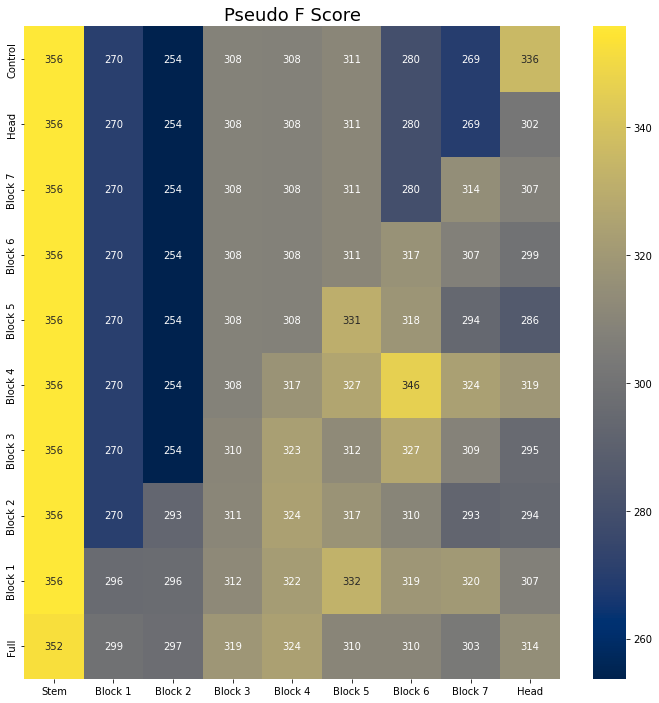

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

"""
for i in range(1,10):
    for j in range(9):
        if j+i<=8:
            acc_list[i][j] = 0
"""

df = pd.DataFrame(F_scores1)
df.columns = ["Stem"] + [f"Block {i+1}" for i in range(7)] + ["Head"]
df.index = ["Control"] + ["Head"] + [f"Block {7-i}" for i in range(7)] + ["Full"]
plt.figure(figsize=(12,12))
plt.title("Pseudo F Score", fontsize=18)
sns.heatmap(df, cmap="cividis", annot=True, fmt=".0f")
plt.savefig("../../outputs/results/230413TGGATEs_FScore_heatmap_MoA.png", bbox_inches="tight", dpi=600)

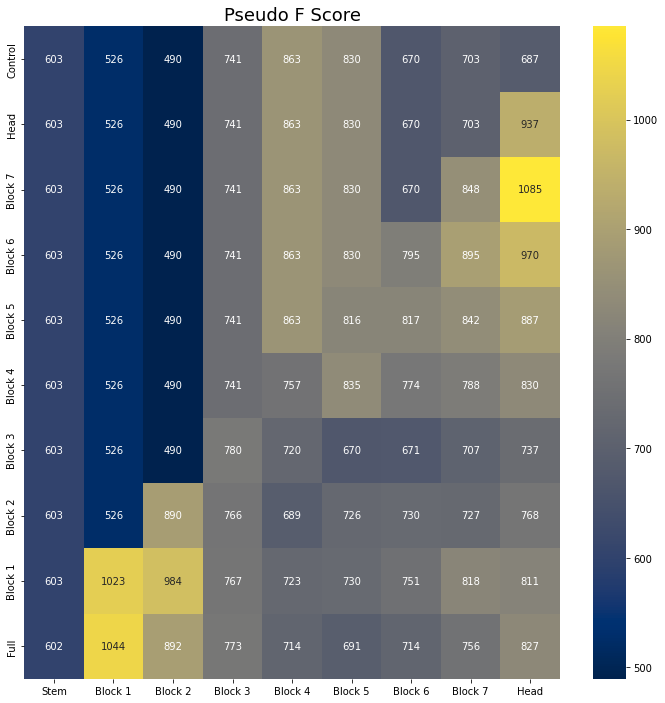

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

"""
for i in range(1,10):
    for j in range(9):
        if j+i<=8:
            acc_list[i][j] = 0
"""

df = pd.DataFrame(F_scores2)
df.columns = ["Stem"] + [f"Block {i+1}" for i in range(7)] + ["Head"]
df.index = ["Control"] + ["Head"] + [f"Block {7-i}" for i in range(7)] + ["Full"]
plt.figure(figsize=(12,12))
plt.title("Pseudo F Score", fontsize=18)
sns.heatmap(df, cmap="cividis", annot=True, fmt=".0f")
plt.savefig("../../outputs/results/230413TGGATEs_FScore_heatmap_compound.png", bbox_inches="tight", dpi=600)

In [19]:
ft_all_list = moa_info_test.columns[77:77+65]
ft_all_list


Index(['Accumulation, foam cell', 'Adenoma, hepatocellular',
       'Alteration, cytoplasmic', 'Alteration, nuclear',
       'Altered hepatocellular foci', 'Anisonucleosis', 'Atrophy',
       'Atypia, nuclear', 'Bacterium', 'Cellular foci',
       'Cellular infiltration', 'Cellular infiltration, mononuclear cell',
       'Cellular infiltration, neutrophil', 'Change, acidophilic',
       'Change, basophilic', 'Change, eosinophilic', 'Congestion', 'Cyst',
       'DEAD', 'Degeneration', 'Degeneration, acidophilic, eosinophilic',
       'Degeneration, fatty', 'Degeneration, granular',
       'Degeneration, granular, eosinophilic', 'Degeneration, hydropic',
       'Degeneration, vacuolar', 'Deposit, glycogen', 'Deposit, hemosiderin',
       'Deposit, lipid', 'Deposit, pigment', 'Dilatation', 'Disarrangement',
       'Ectopic tissue', 'Edema', 'Fibrosis', 'Giant cell', 'Granuloma',
       'Ground glass appearance', 'Hematopoiesis, extramedullary',
       'Hemorrhage', 'Hyperplasia', 'Hypertr

In [20]:
from sklearn.model_selection import GroupKFold, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score


def labeler(y_train, y_valid):
    y_list = list(set(list(y_train)))
    y_list.sort()
    y_dict = {v:k for k,v in enumerate(y_list)}
    return np.array([y_dict[v] if v in y_dict else 100 for v in y_valid])

ft_list = ['Proliferation, bile duct',
 'Ground glass appearance',
 'Increased mitosis',
 'Inclusion body, intracytoplasmic',
 'Deposit, pigment',
 'Single cell necrosis',
 'Vacuolization, cytoplasmic',
 'Swelling']

def create_fold(moa_info_test_f, seed):
    kf = KFold(n_splits=5, shuffle=True, random_state=seed)
    eg = moa_info_test_f["EG"].unique()
    fold = np.zeros(len(eg))
    for i, (_, idx) in enumerate(kf.split(eg)):
        fold[idx] = i
    fold1 = np.zeros(len(moa_info_test_f))
    for i in range(5):
        fold1[moa_info_test_f["EG"].isin(eg[fold==i])] = i
    return fold1

def compound_validation(features, feature_list, moa_tiles, fold):
    macro_acc = []
    acc = []
    if features is not None:
        df = pd.DataFrame(features)
        df["FILE"] = [t.split("/")[-2] for t in moa_tiles]
        df = df.groupby("FILE").mean()
        moa_info_test_f = pd.merge(moa_info_test, df, on = "FILE", how="inner")
    else:
        moa_info_test_f = moa_info_test

    for i in range(5):
        X = moa_info_test_f[feature_list].values
        y = moa_info_test_f["MoA"].values
        X_train = X[fold!=i]
        y_train = y[fold!=i]
        X_valid = X[fold==i]
        y_valid = y[fold==i]
        lr = LogisticRegression(max_iter=10000, n_jobs=8)
        lr.fit(X_train, y_train)
        y_preds = lr.predict_proba(X_valid)
        y_valid = labeler(y_train, y_valid)
        macro_acc.append(balanced_accuracy_score(y_valid, np.argmax(y_preds, axis=1)))
        acc.append([balanced_accuracy_score(y_valid==i, np.argmax(y_preds, axis=1)==i) \
            if (y_valid==i).sum()!=0 else np.nan for i in range(max(moa_info_test_f["MoA"])+1)])
    return macro_acc, acc


df = pd.DataFrame(np.concatenate(features[0][0]))
df["FILE"] = [t.split("/")[-2] for t in moa_tiles]
df = df.groupby("FILE").mean()
_moa_info_test_f = pd.merge(moa_info_test, df, on = "FILE", how="inner")


macro_acc_res = [[[] for j in range(9)] for i in range(10)]
acc_res = [[[] for j in range(9)] for i in range(10)]
for _ in range(10):
    fold = create_fold(_moa_info_test_f, 123+_)
    for i in range(10):
        for j in tqdm(range(9)):
            macro_acc, acc = compound_validation(np.concatenate(features[i][j]), range(np.concatenate(features[i][j]).shape[1]), moa_tiles, fold)
            macro_acc_res[i][j].append(macro_acc)
            acc_res[i][j].append(acc)
        

  0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
 11%|█         | 1/9 [00:03<00:24,  3.12s/it]/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains cl

KeyboardInterrupt: 

In [88]:
ft_macro_acc = []
ft_acc = []
for _ in tqdm(range(10)):
    fold = create_fold(_moa_info_test_f, 123+_)
    macro_acc, acc = compound_validation(np.concatenate(features[0][0]), ft_all_list, moa_tiles, fold)
    ft_macro_acc.append(macro_acc)
    ft_acc.append(acc)

 30%|███       | 3/10 [00:02<00:05,  1.29it/s]/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
 50%|█████     | 5/10 [00:03<00:02,  2.37it/s]/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
 80%|████████  | 8/10 [00:03<00:00,  3.61it/s]/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains c

In [89]:
model_name = ["Control"] + ["Head"] + [f"Block {7-i}" for i in range(7)] + ["Full"]
layer_name = ["Stem"] + [f"Block {i+1}" for i in range(7)] + ["Head"]
rec = []
for i in range(10):
    for j in range(9):
        for k in range(10):
            for l in range(5):        
                rec.append([model_name[i], layer_name[j],k,l, macro_acc_res[i][j][k][l]])
for i in range(10):
    for j in range(5):
        rec.append(["Pathological Findings", "-",i,j, ft_macro_acc[i][j]])
macro_raw_df = pd.DataFrame(rec, columns=["model", "layer", "trial", "fold", "Balanced Accuracy"])

In [91]:
macro_raw_df.to_csv("../../outputs/results/23310compound_validation_macro.csv", index=False)

In [9]:
macro_raw_df = pd.read_csv("../../outputs/results/23310compound_validation_macro.csv")

In [92]:
model_name = ["Control"] + ["Head"] + [f"Block {7-i}" for i in range(7)] + ["Full"]
layer_name = ["Stem"] + [f"Block {i+1}" for i in range(7)] + ["Head"]
rec = []
for i in range(10):
    for j in range(9):
        for k in range(10):
            for l in range(5):        
                rec.append([model_name[i], layer_name[j],k,l] + acc_res[i][j][k][l])
for i in range(10):
    for j in range(5):
        rec.append(["Pathological Findings", "-",i,j] + ft_acc[i][j])
raw_df = pd.DataFrame(rec, columns=["model", "layer", "trial", "fold"] + moa_df.columns[1:8].to_list())

In [93]:
raw_df.to_csv("../../outputs/results/23310compound_validation.csv", index=False)

In [10]:
raw_df = pd.read_csv("../../outputs/results/23310compound_validation.csv")
model_name = ["Control"] + ["Head"] + [f"Block {7-i}" for i in range(7)] + ["Full"]
layer_name = ["Stem"] + [f"Block {i+1}" for i in range(7)] + ["Head"]

layer,Stem,Block 1,Block 2,Block 3,Block 4,Block 5,Block 6,Block 7,Head
model,,,,,,,,,
Control,0.345998,0.413814,0.526049,0.604008,0.709236,0.711745,0.724786,0.688394,0.597996
Head,0.345998,0.413814,0.526049,0.604008,0.709236,0.711745,0.724786,0.688394,0.688507
Block 7,0.345998,0.413814,0.526049,0.604008,0.709236,0.711745,0.724786,0.719661,0.620989
Block 6,0.345998,0.413814,0.526049,0.604008,0.709236,0.711745,0.727495,0.695173,0.610592
Block 5,0.345998,0.413814,0.526049,0.604008,0.709236,0.721306,0.753823,0.727212,0.619005
Block 4,0.345998,0.413814,0.526049,0.604008,0.723310,0.719498,0.713427,0.669601,0.570841
Block 3,0.345998,0.413814,0.526049,0.652890,0.722284,0.702550,0.722104,0.679973,0.575834
Block 2,0.345998,0.413814,0.592364,0.679620,0.705655,0.733453,0.765503,0.723216,0.625342
Block 1,0.345998,0.416875,0.595799,0.664904,0.731634,0.715624,0.727331,0.686707,0.604309


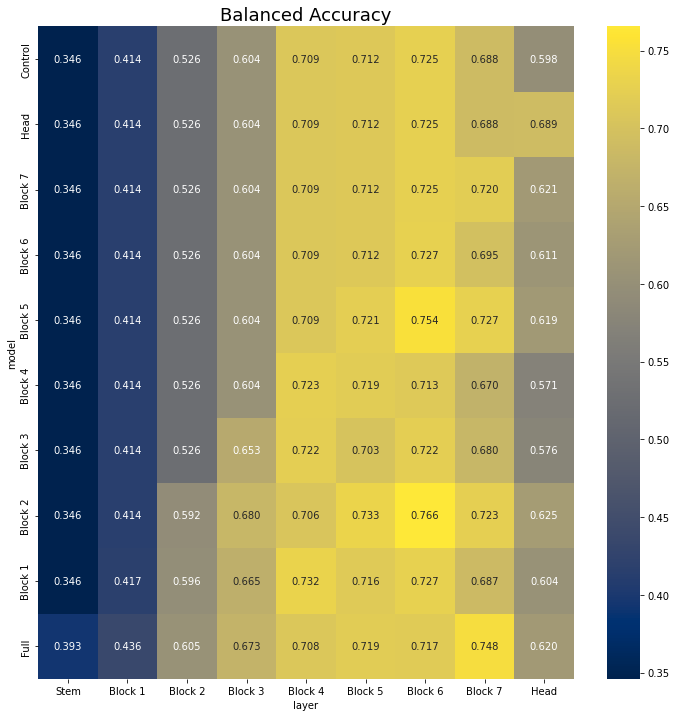

In [29]:
import seaborn as sns
#plt.rcParams["font.size"] = 14
df = pd.pivot_table(macro_raw_df.groupby(["model", "layer"]).mean(),
        index="model", columns="layer", values="Balanced Accuracy")[layer_name].reindex(index=model_name)
plt.figure(figsize=(12,12))
plt.title("Balanced Accuracy", fontsize=18)
sns.heatmap(df, cmap="cividis", annot=True, fmt=".3f")
plt.savefig("../../outputs/results/230310MoA_estimation_heatmap.png", bbox_inches="tight", dpi=600)
plt.show()

In [31]:
np.array(macro_acc_res).reshape(10, 9, 50)[0,-1]

array([0.16666667, 0.2       , 0.2       , 0.2       , 0.14285714,
       0.16666667, 0.16666667, 0.14285714, 0.16666667, 0.16666667,
       0.14285714, 0.14285714, 0.2       , 0.2       , 0.14285714,
       0.2       , 0.14285714, 0.2       , 0.25      , 0.14285714,
       0.14285714, 0.16666667, 0.16666667, 0.16666667, 0.14285714,
       0.2       , 0.14285714, 0.2       , 0.16666667, 0.2       ,
       0.16666667, 0.16666667, 0.2       , 0.16666667, 0.16666667,
       0.2       , 0.16666667, 0.14285714, 0.2       , 0.14285714,
       0.16666667, 0.14285714, 0.16666667, 0.16666667, 0.14285714,
       0.2       , 0.16666667, 0.14285714, 0.2       , 0.16666667])

In [39]:
compound_validation(np.concatenate(features_control), range(np.concatenate(features_control).shape[1]), moa_tiles, fold)

([0.16666666666666666, 0.2, 0.2, 0.2, 0.14285714285714285],
 [[nan, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
  [0.5, nan, 0.5, 0.5, 0.5, 0.5, nan],
  [nan, 0.5, 0.5, 0.5, 0.5, nan, 0.5],
  [nan, nan, 0.5, 0.5, 0.5, 0.5, 0.5],
  [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]])

(array([4.0000e+00, 1.1000e+01, 4.1000e+01, 2.2400e+02, 2.7480e+03,
        1.3892e+04, 2.7899e+04, 1.0114e+04, 9.2000e+01, 1.0000e+00]),
 array([-1.7684467e-06, -1.5679950e-06, -1.3675434e-06, -1.1670917e-06,
        -9.6664007e-07, -7.6618835e-07, -5.6573663e-07, -3.6528496e-07,
        -1.6483330e-07,  3.5618385e-08,  2.3607006e-07], dtype=float32),
 <BarContainer object of 10 artists>)

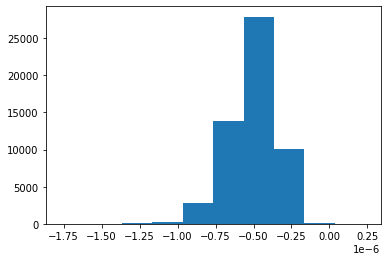

In [42]:
import matplotlib.pyplot as plt
plt.hist(np.concatenate(features_control).mean(axis=1))

In [38]:
np.concatenate(features[0][-1])

array([[-7.26280414e-05, -8.86711769e-06,  9.63320199e-05, ...,
        -1.08650438e-05, -9.34821001e-05,  1.16586591e-04],
       [-2.96115722e-05,  2.64229243e-06,  2.54326260e-05, ...,
         3.73662715e-06, -4.04485108e-05,  4.41595112e-05],
       [-7.52233173e-05,  1.11688223e-08,  9.15246928e-05, ...,
         2.19740696e-06, -1.08133296e-04,  1.12774760e-04],
       ...,
       [-3.95327734e-05,  6.25449411e-06,  6.21797953e-05, ...,
         1.38723535e-05, -9.21636602e-05,  8.74833931e-05],
       [-5.07550649e-05,  1.20256809e-05,  6.37522317e-05, ...,
         1.35470718e-05, -9.85513907e-05,  9.04451081e-05],
       [-4.66039601e-05,  6.90754496e-06,  6.31366856e-05, ...,
         1.42008985e-05, -9.86567320e-05,  8.59594729e-05]], dtype=float32)

In [51]:
from sklearn.decomposition import PCA
def plot_pca(features, com, feature_name):
    plt.rcParams["font.size"] = 14
    f = features
    f_str = np.linalg.norm(f, axis=1)
    df = pd.DataFrame(f)
    df["FILE"] = [t.split("/")[-2] for t in moa_tiles]
    df = df[f_str < np.quantile(f_str, q=0.99)]
    df = df.groupby("FILE").mean()
    moa_info_test_f = pd.merge(moa_info_test, df, on = "FILE", how="inner")
    pca = PCA(n_components=2)
    pcares = pca.fit_transform(moa_info_test_f[range(features.shape[1])])
    print(moa_info_test_f[pcares[:,0]>0.002]["FILE"])
    plt.figure(figsize=(6,6))
    plt.scatter(pcares[:,0], pcares[:,1], s=5, alpha=0.8, color="gray")
    pcares = pcares[moa_info_test_f["COMPOUND_NAME"]==com]
    plt.scatter(pcares[:,0], pcares[:,1], s=15, color="coral", label=com)
    plt.legend()
    plt.title(feature_name, fontsize=18)
    plt.savefig(f"../../outputs/results/compound_pcaplot_{feature_name.replace('/', '_')}.png", bbox_inches="tight", dpi=600)
    plt.show()



Series([], Name: FILE, dtype: object)


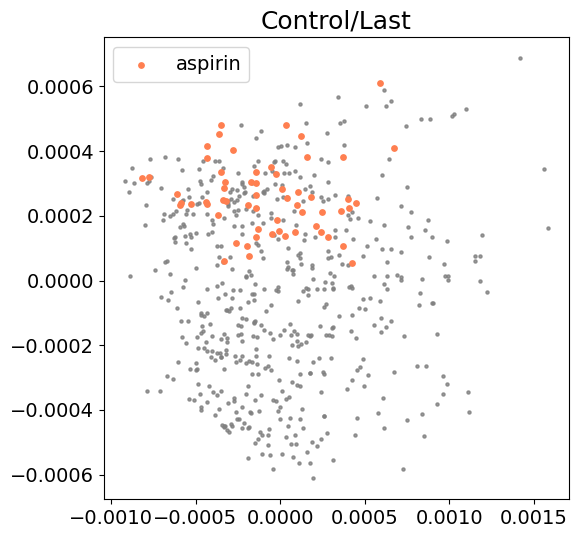

In [57]:
sns.reset_defaults() 

plot_pca(np.concatenate(features[0][-1]), "aspirin", "Control/Last")

0      27980.svs
1      27984.svs
2      27989.svs
3      27992.svs
4      27997.svs
         ...    
583    52112.svs
586    52221.svs
587    52228.svs
589    52461.svs
592    52476.svs
Name: FILE, Length: 216, dtype: object


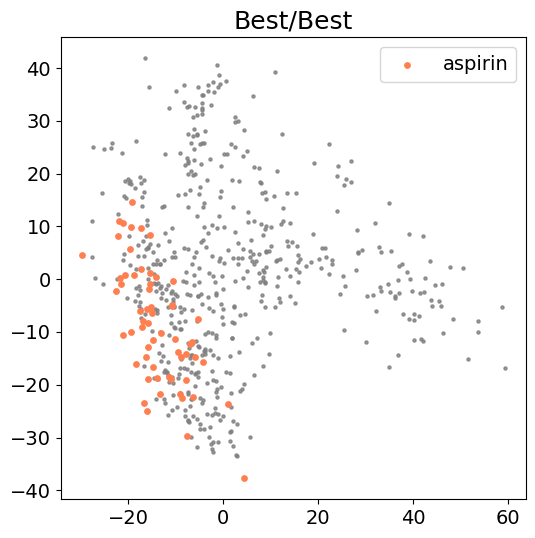

In [53]:
plot_pca(np.concatenate(features[-3][-3]), "aspirin", "Best/Best")

35     28122.svs
73     25036.svs
74     25038.svs
75     25040.svs
76     25042.svs
         ...    
584    52211.svs
589    52461.svs
590    52466.svs
591    52471.svs
593    52481.svs
Name: FILE, Length: 268, dtype: object


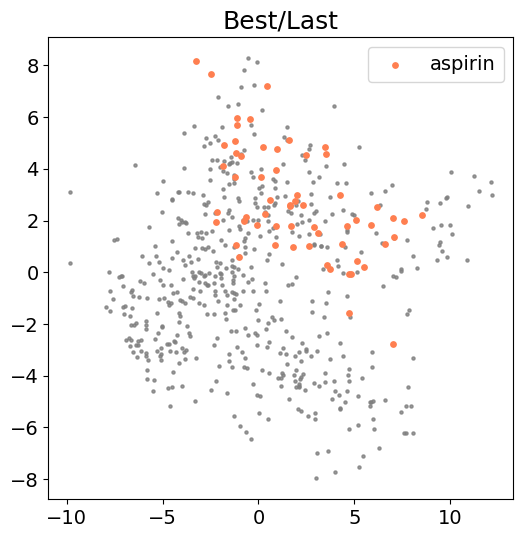

In [54]:
plot_pca(np.concatenate(features[-3][-1]), "aspirin", "Best/Last")

68     26583.svs
72     26591.svs
73     25036.svs
74     25038.svs
75     25040.svs
         ...    
548    40578.svs
554    40591.svs
556    40596.svs
574    40637.svs
577    40643.svs
Name: FILE, Length: 262, dtype: object


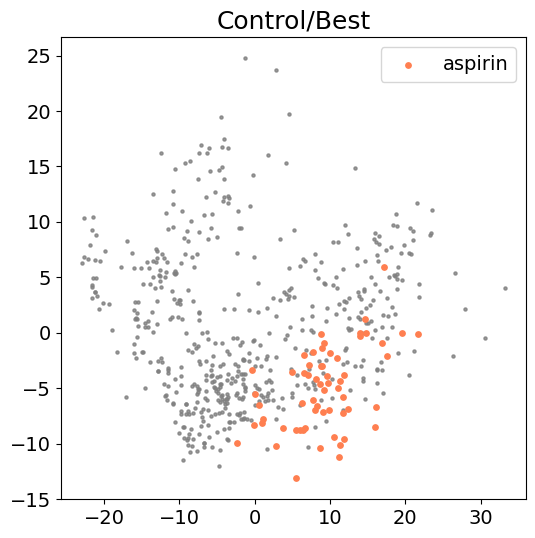

In [56]:
plot_pca(np.concatenate(features[0][-3]), "aspirin", "Control/Best")

0      27980.svs
35     28122.svs
73     25036.svs
74     25038.svs
75     25040.svs
         ...    
574    40637.svs
575    40639.svs
576    40641.svs
577    40643.svs
578    40645.svs
Name: FILE, Length: 314, dtype: object


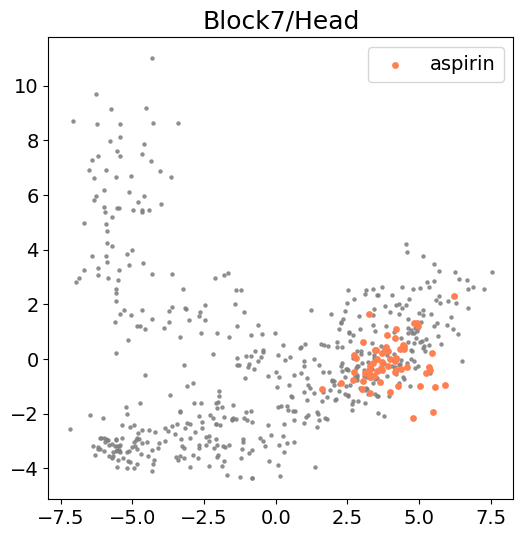

In [49]:
plot_pca(np.concatenate(features[2][-1]), "aspirin", "Block7/Head")

1      27984.svs
2      27989.svs
3      27992.svs
4      27997.svs
5      28001.svs
         ...    
556    40596.svs
574    40637.svs
591    52471.svs
592    52476.svs
593    52481.svs
Name: FILE, Length: 294, dtype: object


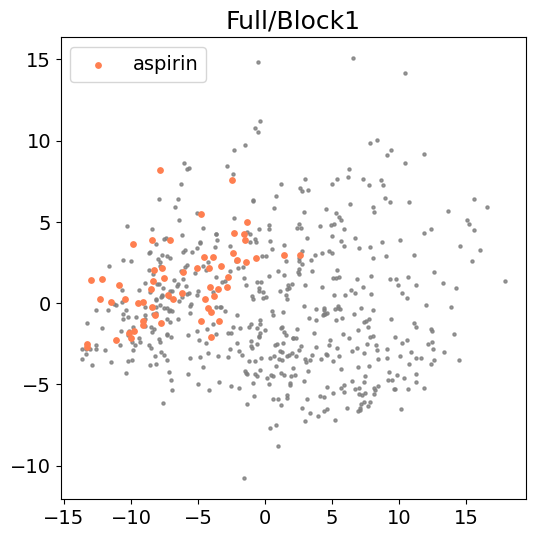

In [50]:
plot_pca(np.concatenate(features[-1][1]), "aspirin", "Full/Block1")

Index(['Bacterial 70S ribosome inhibitor',
       'Serotonin 2a (5-HT2a) receptor antagonist', 'DNA inhibitor',
       'Cyclooxygenase inhibitor', 'Sulfonylurea receptor 1, Kir6.2 blocker',
       'Histamine H2 receptor antagonist',
       'Peroxisome proliferator-activated receptor alpha agonist'],
      dtype='object')

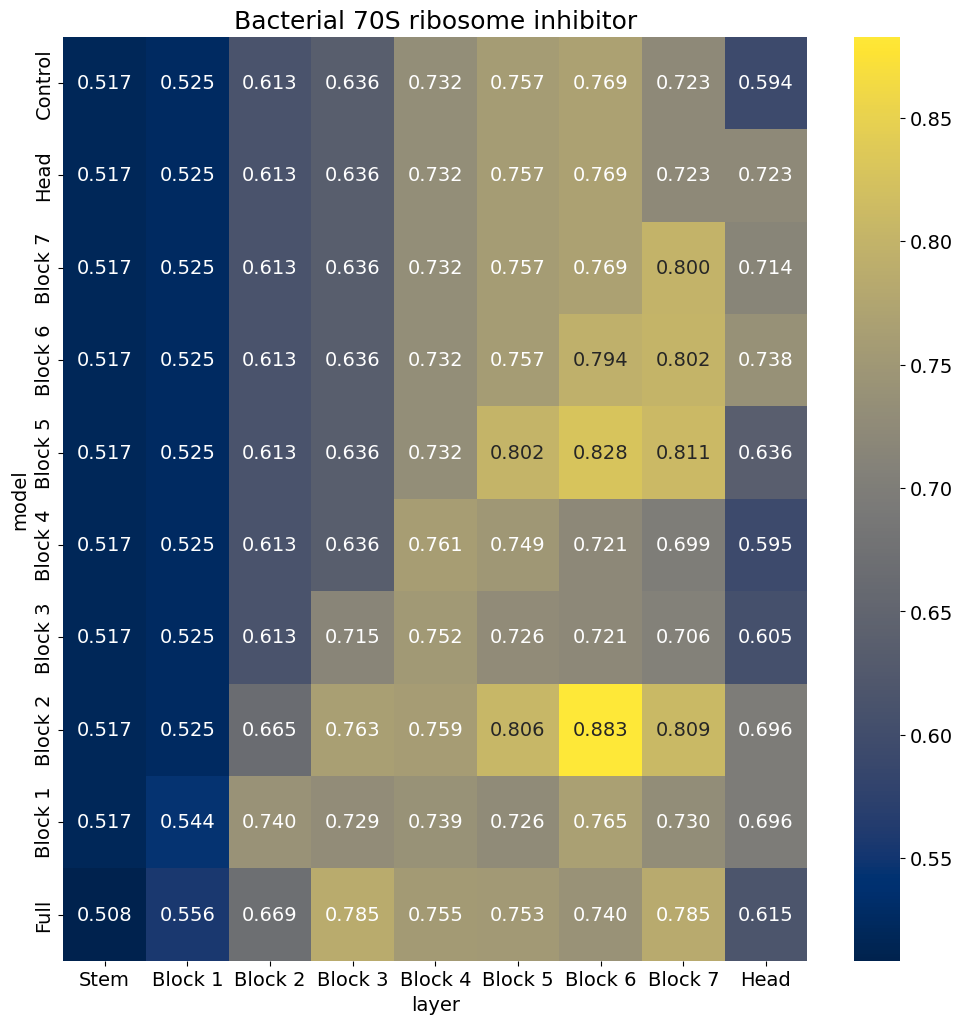

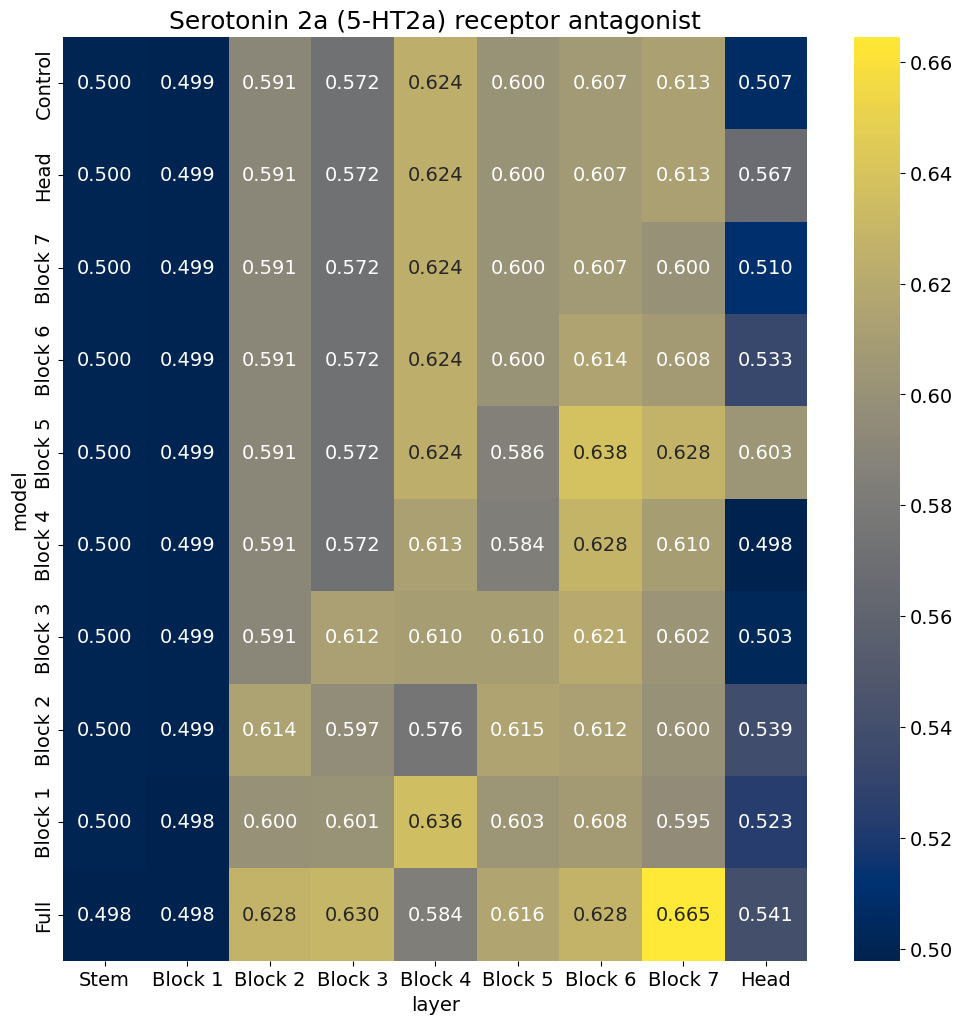

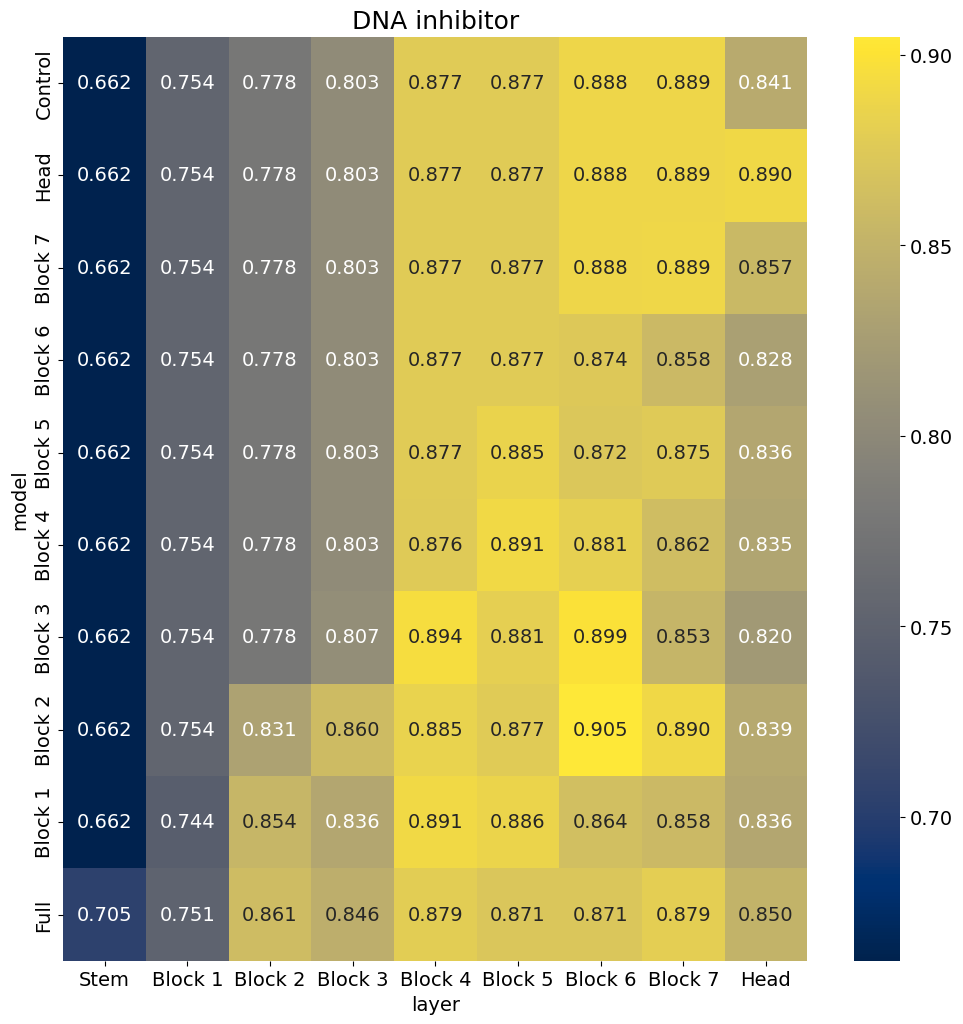

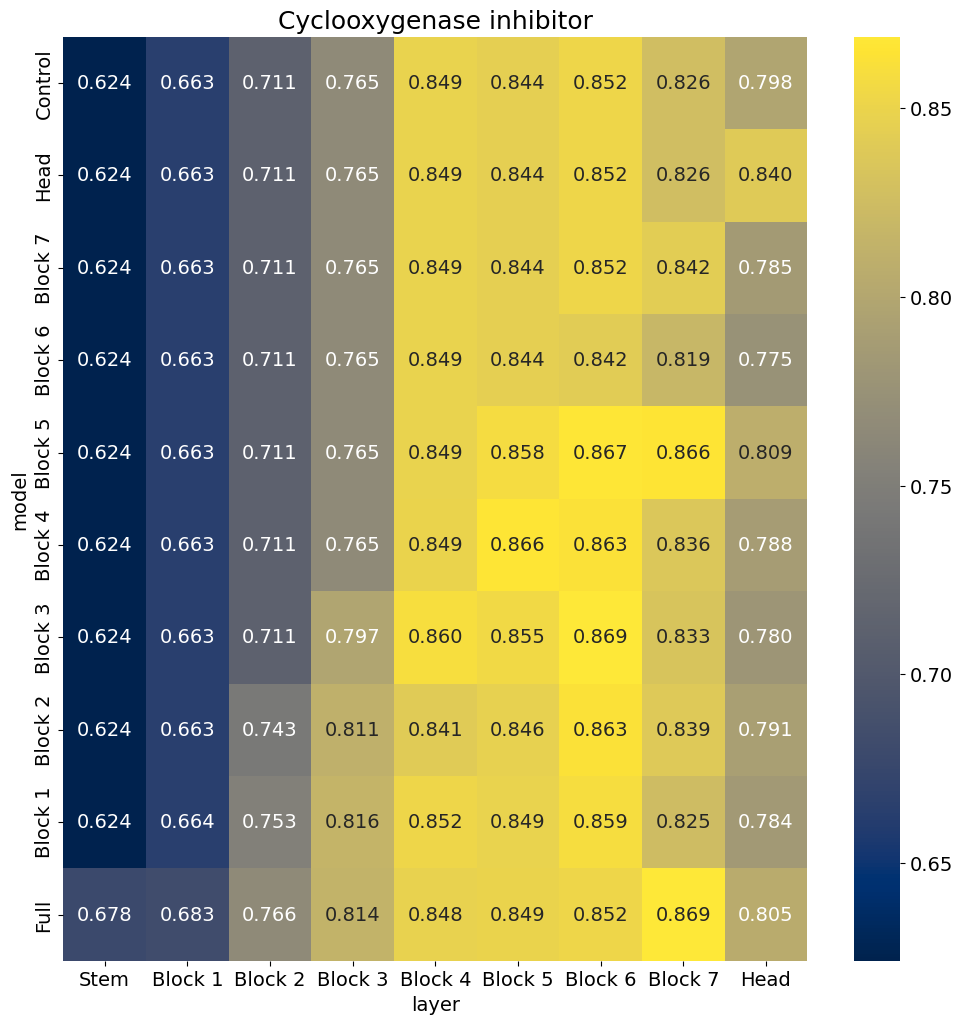

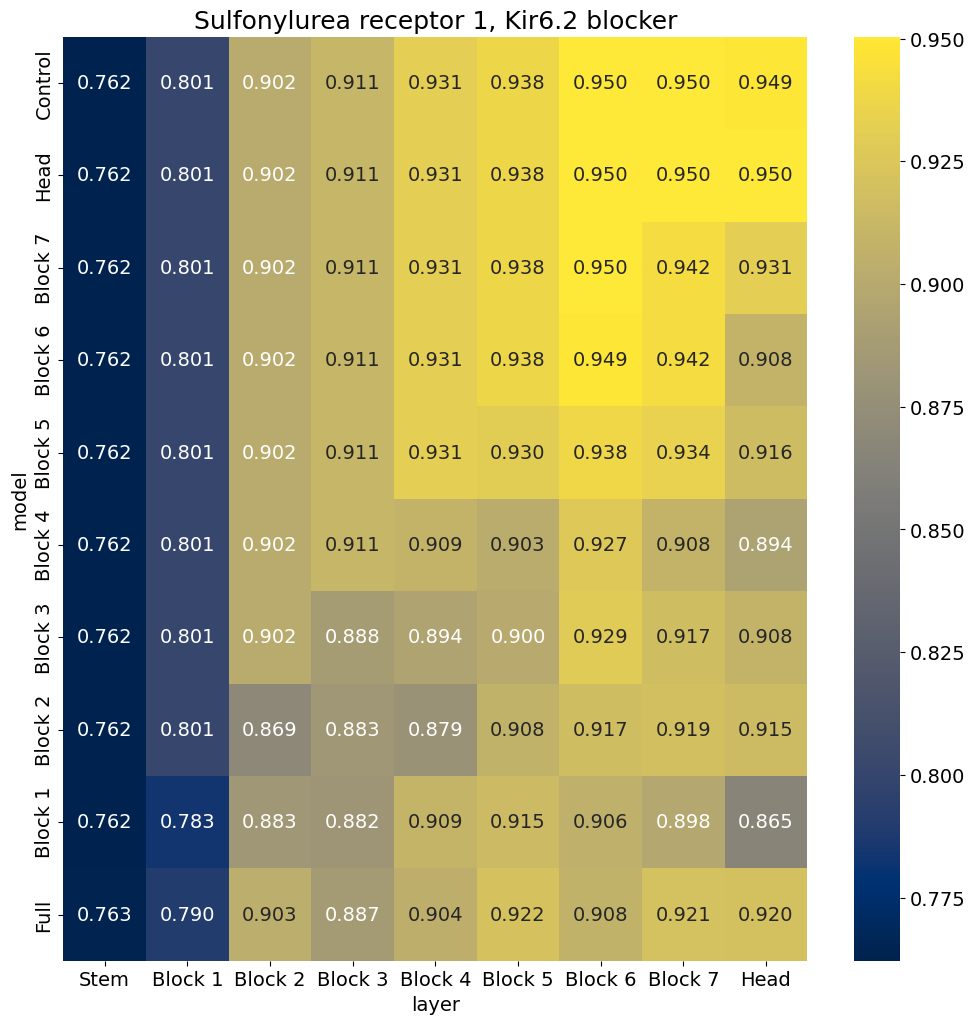

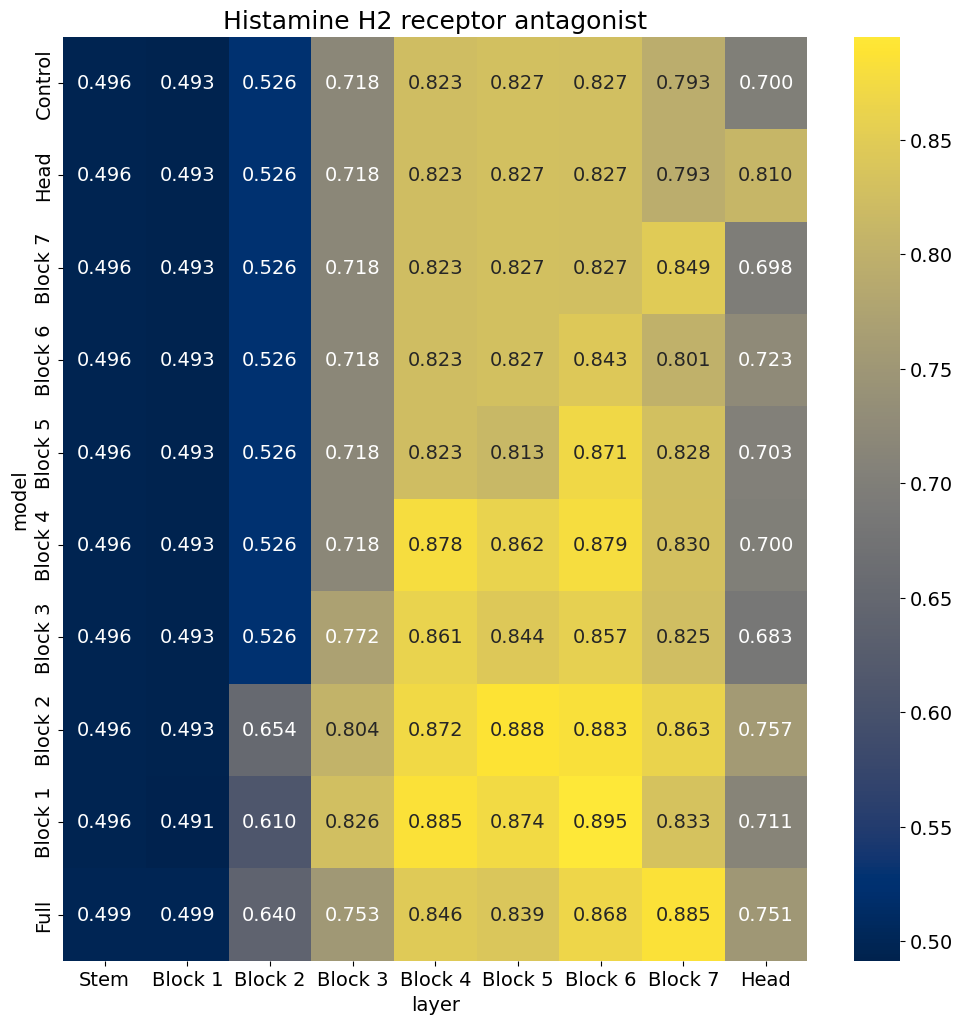

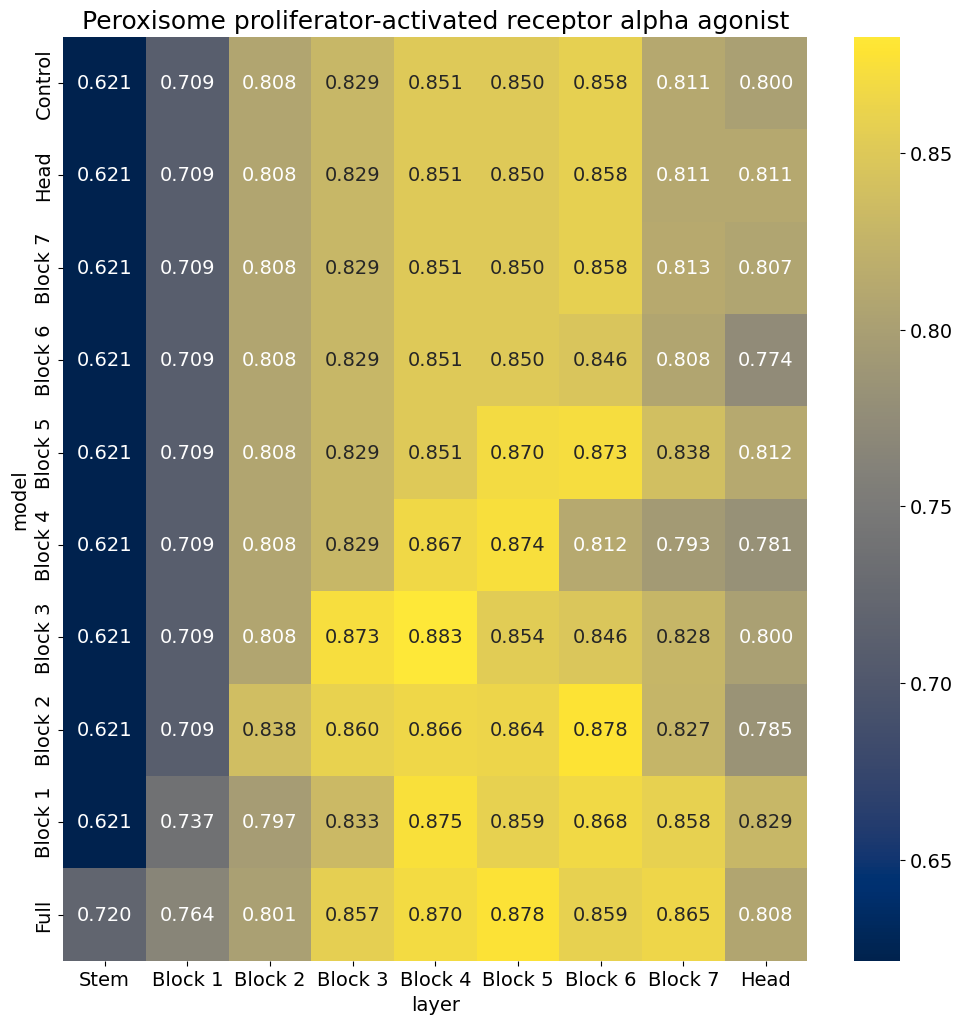

In [62]:
for moa in moa_df.columns[1:8]:
    df = pd.pivot_table(raw_df.groupby(["model", "layer"]).mean(),
                        index="model", columns="layer", values=moa)[layer_name].reindex(index=model_name)
    plt.figure(figsize=(12, 12))
    plt.title(moa, fontsize=18)
    sns.heatmap(df, cmap="cividis", annot=True, fmt=".3f")
    plt.show()


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  from ipykernel import kernelapp as app


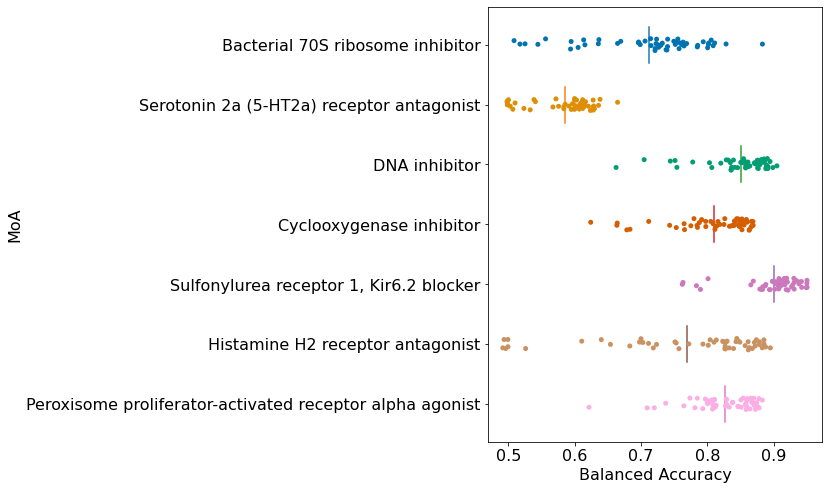

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

data = []
for moa in moa_df.columns[1:8]:
    for i, mn in enumerate(model_name):
        for j, ln in enumerate(layer_name):
            if i+j>=8:
                score = raw_df[(raw_df["model"]==mn) & (raw_df["layer"]==ln)][moa].mean()
                data.append([moa, score])

df = pd.DataFrame(data, columns=["MoA", "Balanced Accuracy"])
plt.figure(figsize=(6,8))
plt.rcParams["font.size"] = 16
sns.stripplot(data=df, x="Balanced Accuracy", y="MoA", palette = "colorblind")
for i, moa in enumerate(moa_df.columns[1:8]):
    x = df[df["MoA"] == moa]["Balanced Accuracy"].mean()
    plt.plot([x,x], [i-0.3, i+0.3])

plt.savefig("../../outputs/results/230414individual_moa.png", bbox_inches="tight", dpi=600)